# Code

In [36]:
from plot_setup import * 
import MCgenerator, dSph_model, coord

In [2]:
prms = {
    "re":r"$r_e[\mathrm{pc}]$",
    "sigmafg":r"\tilde{\Sigma}_\mathrm{FG}"
}
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [7]:
class KI17_loglikelihood_mod:
    def __init__(self,Rs):
        self.Rs = Rs
        self.RoI_R = np.max(Rs) # use Rs.max as the RoI
        print(self.Rs.describe())
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def __call__(self,re,odds):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            loglikelis = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return np.sum(loglikelis)
    def loglikelis(self,re,odds):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            ret = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return ret


In [52]:
class KI17_loglikelihood:
    def __init__(self,Rs):
        self.Rs = Rs
        self.RoI_R = np.max(Rs) # use Rs.max as the RoI
        print(self.Rs)
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def __call__(self,re,s):
        if re<0 or not 0<s<1:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            #s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            loglikelis = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return np.sum(loglikelis)
    def loglikelis(self,re,s):
        if re<0 or not 0<s<1:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            #s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            ret = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return ret
    def s_to_odds(self,s,ref_R):
        mem,fg = self.mem,self.fg
        return mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R)/(1/s-1)

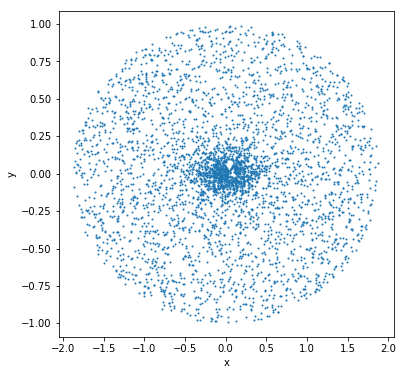

In [4]:
df0 = np.loadtxt("Draco_SDSS_cut_xy1.0.csv",comments="#",delimiter=",")
df_deg = pd.DataFrame(df0,columns=("x","y"))
df_rad = np.deg2rad(pd.DataFrame(df0,columns=("x","y")))
ra0 = draco_prop.RAdeg
de0 = draco_prop.DEdeg
#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.x + ra0
de = df_deg.y + de0
dist = draco_prop.DIST

arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":ra0,"de_center":de0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=dist,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 1
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea628dac8>]],
      dtype=object)

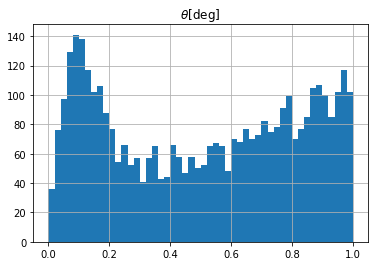

In [5]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2eae0c8748>]],
      dtype=object)

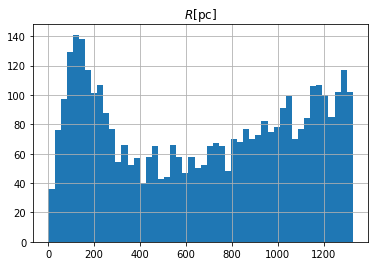

In [6]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

## definition of likelihood

In [8]:
loglikeli = KI17_loglikelihood_mod(Rs[angles<1.0])
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

count    3895.000000
mean      672.749609
std       416.428473
min         1.698731
25%       248.562571
50%       702.831670
75%      1054.806601
max      1325.756354
dtype: float64


In [9]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"odds":6.5},
    dargs_logpdf={"re":5.0,"odds":0.5},
    logpdf_func=loglikeli
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [10]:
Nstep_init = 5000
gen.generate(Nstep_init)

MCgeneration start.
options: {}
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   odds   re  iter_num
0   0.5  5.0      5000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea604f8d0>,
      dtype=object)

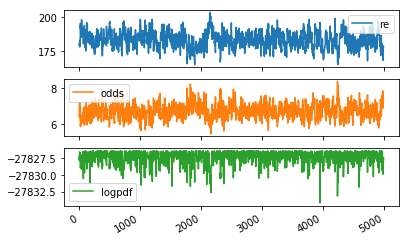

In [11]:
gen.to_DataFrame().plot(subplots=True)

MCgeneration start.
options: {}
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   odds   re  iter_num
0   0.5  5.0      5000
1   0.5  5.0      5000
0th iteration: update dargs_logpdf. 
before:
re      5.0
odds    0.5
dtype: float64
after:
re      6.137237
odds    0.398303
dtype: float64
MCgeneration start.
options: {}
52.710% completed... acceptance rate: 44.94%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
       odds        re  iter_num
0  0.500000  5.000000      5000
1  0.500000  5.000000      5000
2  0.398303  6.137237     10000
1th iteration: update dargs_logpdf. 
before:
re      6.137237
odds    0.398303
dtype: float64
after:
re      6.039228
odds    0.419732
dtype: float64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea5e2e2b0>,
      dtype=object)

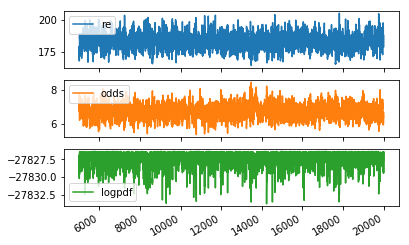

In [12]:
gen.generate_tuned((5000,10000))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea5e5eeb8>,
      dtype=object)

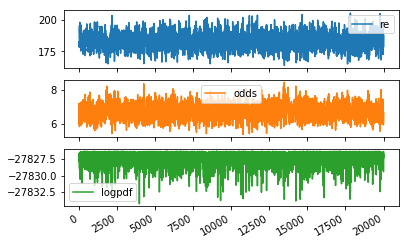

In [13]:
gen.to_DataFrame()[:].plot(subplots=True)

In [25]:
gen.generate(100000)

MCgeneration start.
options: {}
5.419% completed... acceptance rate: 45.03%
10.712% completed... acceptance rate: 44.26%
16.218% completed... acceptance rate: 44.46%
21.683% completed... acceptance rate: 44.66%
27.077% completed... acceptance rate: 44.47%
32.570% completed... acceptance rate: 44.37%
38.045% completed... acceptance rate: 44.31%
43.559% completed... acceptance rate: 44.20%
49.039% completed... acceptance rate: 44.26%
54.537% completed... acceptance rate: 44.32%
59.971% completed... acceptance rate: 44.22%
65.461% completed... acceptance rate: 44.20%
70.843% completed... acceptance rate: 44.24%
76.359% completed... acceptance rate: 44.25%
81.882% completed... acceptance rate: 44.30%
87.321% completed... acceptance rate: 44.34%
92.622% completed... acceptance rate: 44.28%
98.143% completed... acceptance rate: 44.29%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
       odds        re  iter_num
0  0.500000  5.000000      5000
1  0.500000  5.000000      5000
2  0

## results

In [26]:
result_df = gen.to_DataFrame()
resultlog_df = gen.to_DataFrame(output_log=True)
resultlog_df

,odds,re,iter_num
0,0.500000,5.000000,5000
1,0.500000,5.000000,5000
2,0.398303,6.137237,10000
3,0.419732,6.039228,100000
4,0.419732,6.039228,100000


print last 200000 steps


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea4eef860>,
      dtype=object)

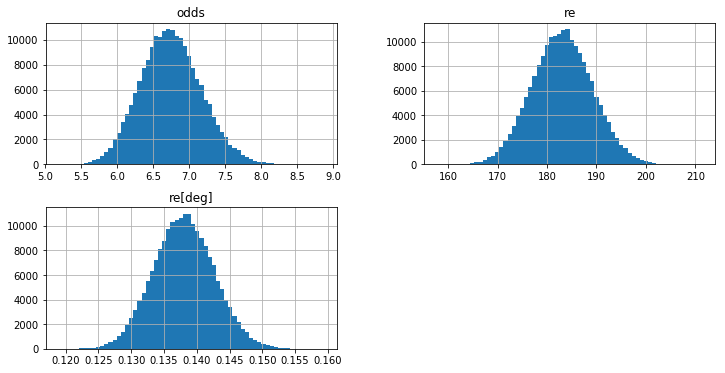

In [29]:
ploted_stepset = 2
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[["re","re[deg]","odds"]][-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

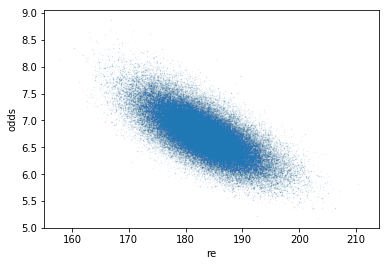

In [38]:
result_df[-200000:].plot.scatter("re","odds",alpha=0.2,s=0.01)
#mypairplot(result_df[-lastMCMCsteps])

In [47]:
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

,re,odds,logpdf,re[deg]
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,183.096524,6.745294,-27827.378956,0.138035
std,6.120130,0.422924,0.998284,0.004614
min,157.786137,5.187492,-27838.680379,0.118954
16%,176.963228,6.323641,-27828.222646,0.133411
50%,183.065289,6.732628,-27827.074614,0.138011
84%,189.189511,7.166214,-27826.547316,0.142628
max,211.343907,8.862036,-27826.371261,0.159330


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea4ae2ac8>],
      dtype=object)

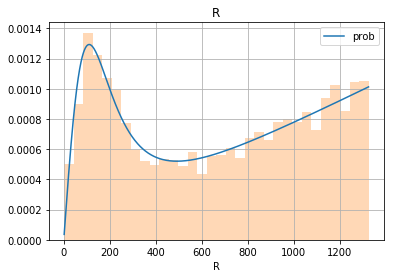

In [50]:
plots_likelis = pd.DataFrame()
plots_likelis["R"] = loglikeli.Rs
plots_likelis["prob"] = np.exp(loglikeli.loglikelis(**(stats[["re","odds"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis.plot(x="R",y="prob",ax=ax)
display(plots_likelis.hist("R",bins=32,density=True,alpha=0.3,ax=ax))

In [51]:
fname = "MCMCresult/MCMC{}_{}_{}.csv"
specify_name = "refR-re"
version="v001"
result_df.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)

# Compare to other results

,odds,re,iter_num
0,0.500000,5.000000,5000
1,0.500000,5.000000,5000
2,0.398303,6.137237,10000
3,0.419732,6.039228,100000
4,0.419732,6.039228,100000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea489d6a0>,
      dtype=object)

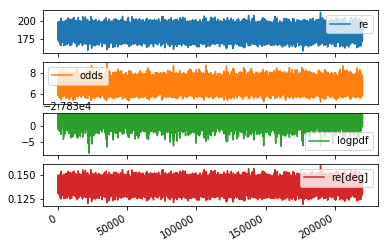

In [54]:
fname_base = "MCMCresult/MCMC{}_{}_{}.csv"
df = pd.read_csv(fname_base.format("","refR-re","v001"))
logdf = pd.read_csv(fname_base.format("log","refR-re","v001"))
display(logdf)
df.plot(subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea46e77f0>,
      dtype=object)

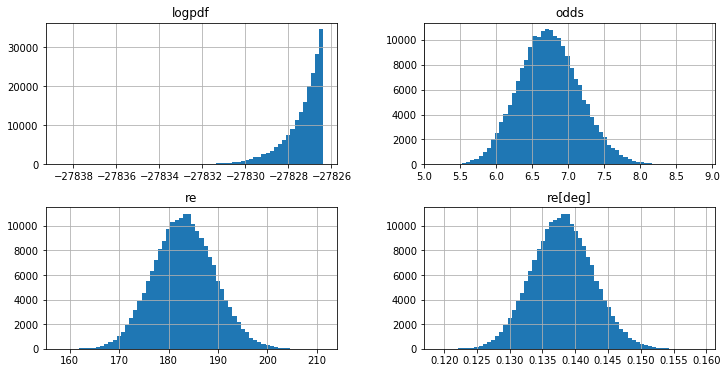

In [56]:
ploted_steps_num = 2
ploted_steps = np.sum(logdf.iter_num[-ploted_steps_num:])
df[-ploted_steps:].hist(bins=64,figsize=(12,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f841463d5c0>,
      dtype=object)

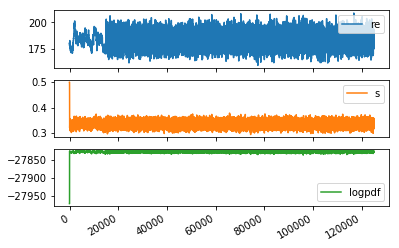

In [25]:
fname_base = "MCMCresult/MCMC{}_{}_{}.csv"
df2 = pd.read_csv(fname_base.format("","KI17","v001"))
logdf2 = pd.read_csv(fname_base.format("log","KI17","v001"))
df2.plot(subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8416843208>,
      dtype=object)

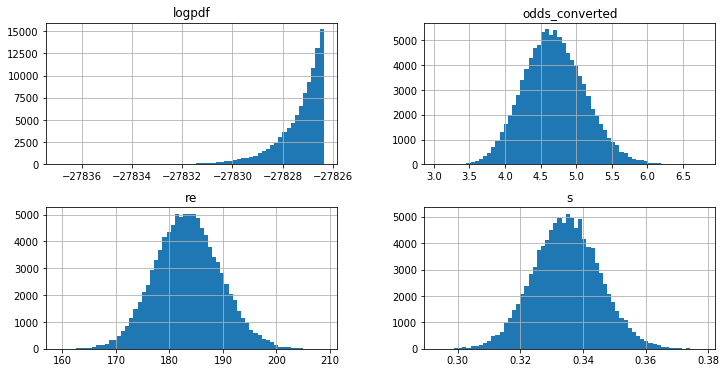

In [47]:
df2[-100000:].hist(bins=64,figsize=(12,6))

In [46]:
df2["odds_converted"]=loglikeli.s_to_odds(df2.s.values,df2.re.values)